In [79]:
import random
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
import enum

ranks = {
    "two" : 2,
    "three" : 3,
    "four" : 4,
    "five" : 5,
    "six" : 6,
    "seven" : 7,
    "eight" : 8,
    "nine" : 9,
    "ten" : 10,
    "jack" : 10,
    "queen" : 10,
    "king" : 10,
    "ace" : (1, 11)
}
    
class Suit(enum.Enum):
    spades = "spades"
    clubs = "clubs"
    diamonds = "diamonds"
    hearts = "hearts"

In [81]:
class Card:
    def __init__(self, suit, rank, value):
        self.suit = suit
        self.rank = rank
        self.value = value
        
    def __str__(self):
        return self.rank + " of " + self.suit.value

class Deck:
    def __init__(self, num=1):
        self.cards = []
        for i in range(num):
            for suit in Suit:
                for rank, value in ranks.items():
                    self.cards.append(Card(suit, rank, value))
                
    def shuffle(self):
        random.shuffle(self.cards)
        
    def deal(self):
        return self.cards.pop(0)
    
    def peek(self):
        if len(self.cards) > 0:
            return self.cards[0]
        
    def add_to_bottom(self, card):
        self.cards.append(card)
        
    def __str__(self):
        result = ""
        for card in self.cards:
            result += str(card) + "\n"
        return result
    
    def __len__(self):
        return len(self.cards)

In [82]:
import random
import numpy as np
import gym
from gym import error, spaces, utils
from gym.utils import seeding

INITIAL_BALANCE = 1000
NUM_DECKS = 6

class BlackjackEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        super(BlackjackEnv, self).__init__()
        
        # Initialize the blackjack deck.
        self.bj_deck = Deck(NUM_DECKS)
        
        self.player_hand = []
        self.dealer_hand = []
        
        self.reward_options = {"lose":-100, "tie":0, "win":100}
        
        # hit = 0, stand = 1
        self.action_space = spaces.Discrete(2)
        
        # Second element of the tuple is the range of possible values for the dealer's upcard. (2 through 11)
        self.observation_space = spaces.Tuple((spaces.Discrete(18), spaces.Discrete(10)))
        
        self.done = False
        
    def _take_action(self, action):
        if action == 0: # hit
            self.player_hand.append(self.bj_deck.deal())
            
        # re-calculate the value of the player's hand after any changes to the hand.
        self.player_value = player_eval(self.player_hand)
    
    def step(self, action):
        self._take_action(action)
        
        # End the episode/game is the player stands or has a hand value >= 21.
        self.done = action == 1 or self.player_value >= 21
        rewards = 0
        
        if self.done:
            # CALCULATE REWARDS
            if self.player_value > 21: 
                rewards = self.reward_options["lose"]
            elif self.player_value == 21:
                rewards = self.reward_options["win"]
            else:
                dealer_value, self.dealer_hand, self.bj_deck = dealer_turn(self.dealer_hand, self.bj_deck)
                if dealer_value > 21: # dealer above 21, player wins automatically
                    rewards = self.reward_options["win"]
                elif dealer_value == 21: # dealer has blackjack, player loses automatically
                    rewards = self.reward_options["lose"]
                else: # dealer and player have values less than 21.
                    if self.player_value > dealer_value: # player closer to 21, player wins.
                        rewards = self.reward_options["win"]
                    elif self.player_value < dealer_value: # dealer closer to 21, dealer wins.
                        rewards = self.reward_options["lose"]
                    else:
                        rewards = self.reward_options["tie"]
        
        self.balance += rewards
        
        
        # Subtract by 1 to fit into the possible observation range.
        # This makes the possible range of 3 through 20 into 1 through 18
        player_value_obs = self.player_value - 2
        
        # get the value of the dealer's upcard, this value is what the agent sees.
        # Subtract by 1 to fit the possible observation range of 1 to 10.
        upcard_value_obs = dealer_eval([self.dealer_upcard]) - 1
        
        # the state is represented as a player hand-value + dealer upcard pair.
        obs = np.array([player_value_obs, upcard_value_obs])
        
        return obs, rewards, self.done, {}
    
    def reset(self): # resets game to an initial state
        # Add the player and dealer cards back into the deck.
        self.bj_deck.cards += self.player_hand + self.dealer_hand

        # Shuffle before beginning. Only shuffle once before the start of each game.
        self.bj_deck.shuffle()
         
        self.balance = INITIAL_BALANCE
        
        self.done = False
        
        # returns the start state for the agent
        # deal 2 cards to the agent and the dealer
        self.player_hand = [self.bj_deck.deal(), self.bj_deck.deal()]
        self.dealer_hand = [self.bj_deck.deal(), self.bj_deck.deal()]
        self.dealer_upcard = self.dealer_hand[0]
        
        # calculate the value of the agent's hand
        self.player_value = player_eval(self.player_hand)
        
        # Subtract by 1 to fit into the possible observation range.
        # This makes the possible range of 2 through 20 into 1 through 18
        player_value_obs = self.player_value - 2
            
        # get the value of the dealer's upcard, this value is what the agent sees.
        # Subtract by 1 to fit the possible observation range of 1 to 10.
        upcard_value_obs = dealer_eval([self.dealer_upcard]) - 1
        
        # the state is represented as a player hand-value + dealer upcard pair.
        obs = np.array([player_value_obs, upcard_value_obs])
        
        return obs
    
    def render(self, mode='human', close=False):
        # convert the player hand into a format that is
        # easy to read and understand.
        hand_list = []
        for card in self.player_hand:
            hand_list.append(card.rank)
            
        # re-calculate the value of the dealer upcard.
        upcard_value = dealer_eval([self.dealer_upcard])
        
        print(f'Balance: {self.balance}')
        print(f'Player Hand: {hand_list}')
        print(f'Player Value: {self.player_value}')
        print(f'Dealer Upcard: {upcard_value}')
        print(f'Done: {self.done}')
        
        print()


In [83]:
env = BlackjackEnv()

total_rewards = 0
NUM_EPISODES = 1000

for _ in range(NUM_EPISODES):
    env.reset()
    
    episode_reward = 0
    while env.done == False:
        action = env.action_space.sample()

        new_state, reward, done, desc = env.step(action)
        
        episode_reward += reward
        
    total_rewards += episode_reward
        
avg_reward = total_rewards / NUM_EPISODES
print(avg_reward)

-27.9


In [84]:
def run_mc(env, num_episodes):
    Q = np.zeros([env.observation_space[0].n * env.observation_space[1].n, env.action_space.n], dtype=np.float16)


    #Probability distributions for each action (hit or stand) given a state.
    prob = np.zeros([env.observation_space[0].n * env.observation_space[1].n, env.action_space.n], dtype=np.float16) + 0.5

    alpha = 0.001

    epsilon = 1
    
    # The rate by which epsilon will decay over time.
    decay = 0.9999
    
    # The lowest value that epsilon can go to.
    epsilon_min = 0.9

    # may have to be tweaked.
    gamma = 0.8
    
    for _ in range(num_episodes):
        episode = play_game(env, Q, prob)
        
        epsilon = max(epsilon * decay, epsilon_min)
        
        Q = update_Q(env, episode, Q, alpha, gamma)
        prob = update_prob(env, episode, Q, prob, epsilon)
        
    return Q, prob

In [85]:
def play_game(env, Q, prob):
    # Can contain numerous state->action->reward tuples because a round of 
    # Blackjack is not always resolved in one turn.
    episode = []
    
    state = env.reset()
    
    while env.done == False:
        if state[0] == 19:
            next_state, reward, env.done, info = env.step(1)
        else:
            Q_state_index = get_Q_state_index(state)
            
            # Use the index to get the possible actions. Index 0 is hit, index 1 is stand.
            best_action = np.argmax(Q[Q_state_index])
            
            # Go to the prob table to retrieve the probability of this action.
            prob_of_best_action = get_prob_of_best_action(env, state, Q, prob)

            action_to_take = None

            if random.uniform(0,1) < prob_of_best_action: # Take the best action
                action_to_take = best_action
            else: # Take the other action
                action_to_take = 1 if best_action == 0 else 0
            
            # The agent does the action, and we get the next state, the rewards,
            # and whether the game is now done.
            next_state, reward, env.done, info = env.step(action_to_take)
            
            # We now have a state->action->reward sequence we can log
            # in `episode`
            episode.append((state, action_to_take, reward))
            
            # update the state for the next decision made by the agent.
            state = next_state
        
    return episode

In [86]:
def update_Q(env, episode, Q, alpha, gamma):
    step = 0
    for state, action, reward in episode:
        # calculate the cumulative reward of taking this action in this state.
        # Start from the immediate rewards, and use all the rewards from the
        # subsequent states. Do not use rewards from previous states.
        total_reward = 0
        gamma_exp = 0
        for curr_step in range(step, len(episode)):
            curr_reward = episode[curr_step][2]
            total_reward += (gamma ** gamma_exp) * curr_reward
            gamma_exp += 1
        
        # Update the Q-value
        Q_state_index = get_Q_state_index(state)
        curr_Q_value = Q[Q_state_index][action]
        Q[Q_state_index][action] = curr_Q_value + alpha * (total_reward - curr_Q_value)
        
        # update step to start further down the episode next time.
        step += 1
        
        
    return Q

In [87]:
def update_prob(env, episode, Q, prob, epsilon):
    for state, action, reward in episode:
        # Update the probabilities of the actions that can be taken given the current
        # state.
        prob = update_prob_of_best_action(env, state, Q, prob, epsilon)
        
    return prob

In [88]:
# Given a state, derive the corresponding index in the Q-array.
# The state is a player hand value + dealer upcard pair.
def get_Q_state_index(state):
    # the player value is already subtracted by 1 in the env when it returns the state.
    # subtract by 1 again to fit with the array indexing that starts at 0
    initial_player_value = state[0] - 1
    # the upcard value is already subtracted by 1 in the env when it returns the state.
    # dealer_upcard will be subtracted by 1 to fit with the array indexing that starts at 0
    dealer_upcard = state[1] - 1

    return (env.observation_space[1].n * (initial_player_value)) + (dealer_upcard)

In [89]:
def get_prob_of_best_action(env, state, Q, prob):
    # Use the mapping function to figure out which index of Q corresponds to 
    # the player hand value + dealer upcard value that defines each state.
    Q_state_index = get_Q_state_index(state)
    
    # Use the np.argmax() function to find the index of the action that yields the
    # rewards i.e. the best action we are looking for.
    best_action = np.argmax(Q[Q_state_index])
    
    # Retrieve the probability of the best action using the 
    # state/action pair as indices for the `prob` array
    return prob[Q_state_index][best_action]
    
def update_prob_of_best_action(env, state, Q, prob, epsilon):

    Q_state_index = get_Q_state_index(state)
    
    best_action = np.argmax(Q[Q_state_index])
    
    prob[Q_state_index][best_action] = min(1, prob[Q_state_index][best_action] + 1 - epsilon)
    
    other_action = 1 if best_action == 0 else 0
    prob[Q_state_index][other_action] = 1 - prob[Q_state_index][best_action]
    
    return prob

In [90]:
import time
env = BlackjackEnv()

start_time = time.time()
new_Q, new_prob = run_mc(env, 1000000)
end_time = time.time()

print("Total Time for Learning: " + str(end_time - start_time))

Total Time for Learning: 235.92281222343445


In [91]:
def best_policy(Q):
    best_policy_binary = []
    best_policy_string = []
    best_policy_colors = []
    for i in range(len(Q)):
        best_policy_binary.append(np.argmax(Q[i]))
        best_policy_string.append("H" if np.argmax(Q[i]) == 0 else "S")
        best_policy_colors.append("g" if np.argmax(Q[i]) == 0 else "r")
        
    return best_policy_binary, best_policy_string, best_policy_colors

In [92]:
import pandas as pd
new_Q_binary, new_Q_string, new_Q_colors = best_policy(new_Q)

df = pd.DataFrame(columns = range(2, 12))

color_df = pd.DataFrame(columns = range(2, 12))

for s in range(3, 21): 
    start = env.observation_space[1].n * (s-3)
    end = start + 10
    df.loc[s]=(new_Q_string[start:end])
    color_df.loc[s]=(new_Q_colors[start:end])

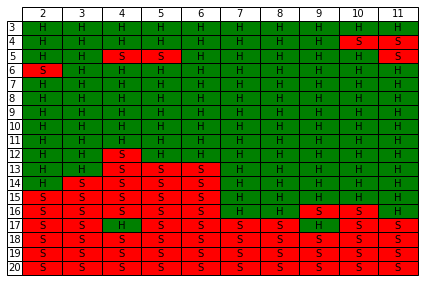

In [93]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.set_axis_off()
ax.axis('tight')

ax.table(cellText=df.values, cellColours=color_df.values, cellLoc="center", rowLabels=df.index, colLabels=df.columns, loc='center')

fig.tight_layout()

plt.show()

In [94]:
import random
env = BlackjackEnv()

total_rewards = 0
NUM_EPISODES = 100000

for _ in range(NUM_EPISODES):
    state = env.reset()

    while env.done == False:
        if state[0] == 19: # Player was dealt Blackjack
            next_state, reward, env.done, info = env.step(1) # doesn't matter what action is taken.
            # don't do any episode analysis for this episode. This is a useless episode.
            total_rewards += reward
        else:
            Q_index = get_Q_state_index(state)
            action = new_Q_binary[Q_index]

            new_state, reward, done, desc = env.step(action)
            state = new_state
            total_rewards += reward
        
avg_reward = total_rewards / NUM_EPISODES
print(avg_reward)

-4.966
